In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

Data Source : https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")

print("Path to dataset file:", path)

Path to dataset file: /kaggle/input/bitcoin-historical-data


In [3]:
df = pd.read_csv(f"{path}/btcusd_1-min_data.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="s", utc=True)

df = df.sort_values("Timestamp").tail(90000) # Past two months

Prototype : A very naive `signal simulator` for now

In [4]:
LOOKBACK = 60         # minutes in each sample (can tune)
HORIZON  = 10          # predict direction ten minutes into the future
THRESH   = np.log(1.001)      # “no‑trade” buffer for HOLD. Atleast 0.01 % increase for signals.

df["Return"] = np.log(df["Close"].shift(1) / df["Close"])
df["Fut_ret"] = np.log(df["Close"].shift(HORIZON) / df["Close"])
df['Abs'] = np.where (np.abs(df['Fut_ret'])  >  THRESH,  1, 0)
df['Target'] = np.where ( # Signal Simulator
    df['Fut_ret']  >  THRESH,  1,
    np.where(df['Fut_ret'] < -THRESH, -1, 0)
    )
df["Abs"].mean()

np.float64(0.3775)

Our `THRESH` parameter for Threshold is selected such that we get opportunities ~ 33% of the times in the form of a BUY / SELL signal

In [5]:
data = df[["Return", "Target"]]
data.describe()

,Return,Target
count,89999.000000,90000.000000
mean,-0.000001,-0.007389
std,0.000477,0.614369
min,-0.005407,-1.000000
25%,-0.000196,0.000000
50%,0.000000,0.000000
75%,0.000192,0.000000
max,0.007980,1.000000


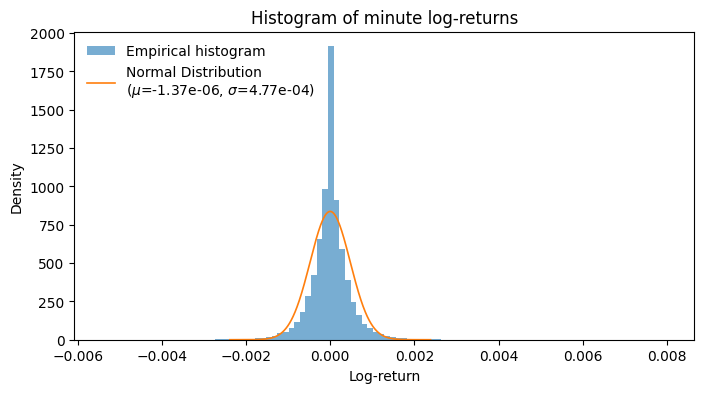

In [6]:
from scipy import stats

# log‑returns, NaNs already dropped
r = df["Return"].dropna().values
mu, sigma = r.mean(), r.std(ddof=0)

fig, ax = plt.subplots(figsize=(8, 4))

# empirical histogram
ax.hist(r, bins=100, density=True, alpha=0.6,
        label="Empirical histogram")

# theoretical normal PDF
x = np.linspace(mu - 5 * sigma, mu + 5 * sigma, 1_000)
ax.plot(x, stats.norm.pdf(x, mu, sigma),
        linewidth=1.2, label=f"Normal Distribution \n($\\mu$={mu:.2e}, $\\sigma$={sigma:.2e})")

ax.set_title("Histogram of minute log‑returns")
ax.set_xlabel("Log‑return")
ax.set_ylabel("Density")
ax.legend(loc="upper left", frameon=False)
plt.show()

Our Data can be assumed close to Log Normal

In [7]:
data.dropna(inplace=True)

/tmp/ipython-input-7-1368182302.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [8]:
ret = data['Return'].values
target = data['Target'].values

X, y = [], []
for i in range(LOOKBACK, len(ret) - HORIZON):   # ensure future_ret and lookback data exists
    X.append(ret[i-LOOKBACK:i])
    y.append(target[i])

X = np.array(X, dtype=np.float32)
y = np.array(y,   dtype=np.int8)

In [9]:
# Add channel‑dim: (samples, timesteps, features)
X = X[..., np.newaxis]            # single feature channel

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_enc = le.fit_transform(y)

Split into train, val, test

In [10]:
N = len(X)
train_end = int(0.75 * N)
val_end   = int(0.85 * N)

X_train, y_train = X[:train_end], y_enc[:train_end]
X_val,   y_val   = X[train_end:val_end], y_enc[train_end:val_end]
X_test,  y_test  = X[val_end:], y_enc[val_end:]

print(f"Shapes → train: {X_train.shape}, val: {X_val.shape}, test: {X_test.shape}")

Shapes → train: (67446, 60, 1), val: (8993, 60, 1), test: (13490, 60, 1)


In [11]:
def build_model(conv_filters=64, kernel_size=5,
                lstm_units=32, dense_units=64,
                dropout_rate=0.15):

    inputs = keras.Input(shape=(LOOKBACK, 1))
    x = keras.layers.Conv1D(conv_filters, kernel_size,
                            padding='causal', activation='relu')(inputs)
    x = keras.layers.SpatialDropout1D(dropout_rate)(x)

    x = tf.keras.layers.LSTM(lstm_units)(x)

    x = keras.layers.Dense(dense_units, activation='relu')(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(dense_units//2, activation='relu')(x)

    outputs = keras.layers.Dense(3, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    return model

In [12]:
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Visible devices:", tf.config.list_physical_devices('GPU'))
print("Default GPU device:", tf.test.gpu_device_name())

Built with CUDA: True
Visible devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU device: /device:GPU:0


In [13]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight='balanced',
                                classes=np.unique(y_train),
                                y=y_train)
class_weights = dict(enumerate(weights))
class_weights

{0: np.float64(1.672394554786878),
 1: np.float64(0.546170104219809),
 2: np.float64(1.7509345794392523)}

In [14]:
model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 60, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 60, 64)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,091 (66.76 KB)

 Trainable params: 17,091 (66.76 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
BATCH = 1024
EPOCHS = 50

optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=10, restore_best_weights=True
)

In [16]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    epochs=EPOCHS,
    batch_size=BATCH,
    callbacks=[early_stop]
)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.2454 - loss: 1.0990 - val_accuracy: 0.2097 - val_loss: 1.0982
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4157 - loss: 1.0942 - val_accuracy: 0.1909 - val_loss: 1.1039
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2074 - loss: 1.0966 - val_accuracy: 0.1913 - val_loss: 1.0979
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2309 - loss: 1.0973 - val_accuracy: 0.3688 - val_loss: 1.0754
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3556 - loss: 1.0185 - val_accuracy: 0.6139 - val_loss: 0.8632
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5561 - loss: 0.7554 - val_accuracy: 0.7089 - val_loss: 0.6890
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6731 - loss: 0.6169 - val_accuracy: 0.7078 - val_loss: 0.6644
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6932 - loss: 0.5749 - val_accuracy: 0.7109 - v

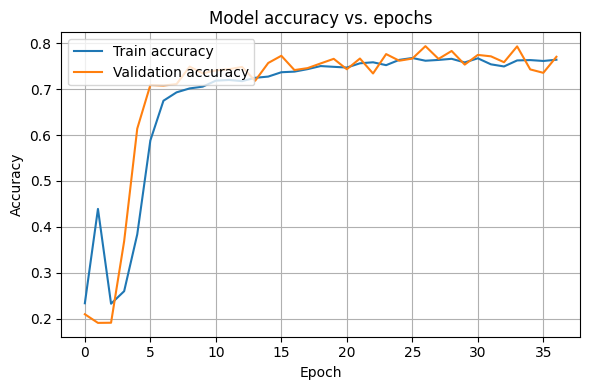

In [17]:
acc      = history.history.get("accuracy",      history.history.get("acc"))
val_acc  = history.history.get("val_accuracy",  history.history.get("val_acc"))

plt.figure(figsize=(6,4))
plt.plot(acc,     label="Train accuracy")
plt.plot(val_acc, label="Validation accuracy")
plt.title("Model accuracy vs. epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
results = model.evaluate(X_test, y_test,
                         batch_size=1024,
                         return_dict=True, verbose=2)

print("Test accuracy:", results['accuracy'])

14/14 - 0s - 8ms/step - accuracy: 0.8373 - loss: 0.4280
Test accuracy: 0.8372868895530701


83.7% Accuracy is great.

This plot implies that for now we have no overfitting

We can try to increase the number of parameters.

In [19]:
model2 = build_model(conv_filters=128, kernel_size=7,
                lstm_units=64, dense_units=96, dropout_rate=0.2)
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 60, 128)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 60, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         6,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 48)             │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,475 (240.14 KB)

 Trainable params: 61,475 (240.14 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
EPOCHS = 100
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=15, restore_best_weights=True
)

optimizer = keras.optimizers.Adam()
model2.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    epochs=EPOCHS,
    batch_size=BATCH,
    callbacks=[early_stop],
)

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.2852 - loss: 1.1009 - val_accuracy: 0.1909 - val_loss: 1.0996
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2285 - loss: 1.1000 - val_accuracy: 0.5994 - val_loss: 1.0973
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2843 - loss: 1.1005 - val_accuracy: 0.2097 - val_loss: 1.0952
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.2442 - loss: 1.0899 - val_accuracy: 0.4956 - val_loss: 0.9798
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4830 - loss: 0.8479 - val_accuracy: 0.7192 - val_loss: 0.6663
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7031 - loss: 0.5650 - val_accuracy: 0.7713 - val_loss: 0.5586
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7432 - loss: 0.5008 - val_accuracy: 0.7710 - val_loss: 0.5468
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7506 - loss: 0.4833 - val_accuracy: 0.

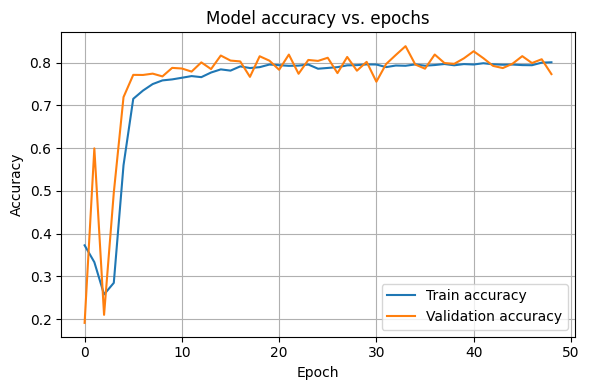

In [21]:
acc      = history.history.get("accuracy",      history.history.get("acc"))
val_acc  = history.history.get("val_accuracy",  history.history.get("val_acc"))

plt.figure(figsize=(6,4))
plt.plot(acc,     label="Train accuracy")
plt.plot(val_acc, label="Validation accuracy")
plt.title("Model accuracy vs. epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
results = model2.evaluate(X_test, y_test,
                         batch_size=1024,
                         return_dict=True, verbose=2)

print("Test accuracy:", results['accuracy'])

14/14 - 0s - 14ms/step - accuracy: 0.8762 - loss: 0.3040
Test accuracy: 0.8762046098709106


great improvement

In [ ]:
model2.save('model_0.keras')

Now let's visualize how well our predictions look on unseen data